In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import numpy as np
from torch.distributions.normal import Normal
import warnings
warnings.filterwarnings('ignore')

# device, cuda if available else use cpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# **1 - Download Mnist :**
* Transformations defined for loading :
    * Convert the image to a tensor.
    * Converting to a tensor automatically converts image to [0, 1] .

In [2]:
# list of transformations to apply to the data
transform = transforms.Compose([
    transforms.ToTensor()])

# download train and test set
train = datasets.MNIST(root='./mnist_data/', train=True, transform=transform, download=True)
test = datasets.MNIST(root='./mnist_data/', train=False, transform=transform, download=False)

# **2 - Define the network's architecture :**
* Encoder and Decoder and then the full network (VAE) :

## 2-1- Encoder and Decoder with linear layers :

In [3]:
class Encoder(nn.Module):
    """
    VAE Encoder with linear layers
    """
    def __init__(self, dim_input, hidden, dim_z):
        super().__init__()
        self.lin1 = nn.Linear(dim_input, hidden)
        # generate covariance matrix (hyp : diagonal)
        self.sigma = nn.Linear(hidden, dim_z)
        # genrate mean vector 
        self.mu = nn.Linear(hidden, dim_z)
    def forward(self, x):
        lin1 = F.relu(self.lin1(x))
        #we infer log(sigma**2) for stability reasons
        log_sigma_squared = self.sigma(lin1) 
        mu = self.mu(lin1)
        return mu, log_sigma_squared

In [4]:
class Decoder(nn.Module):
    """
    VAE Decoder with linear layers
    """
    def __init__(self, dim_input, hidden, dim_z):
        super().__init__()
        self.lin1 = nn.Linear(dim_z, hidden)
        self.lin2 = nn.Linear(hidden, dim_input)
    def forward(self, x):
        lin1 = F.relu(self.lin1(x))
        x = torch.sigmoid(self.lin2(lin1))
        return x  

In [5]:
class VAE(nn.Module):
    """
    VAE with linear layers based Encoder and Decoder
    """
    def __init__(self, dim_input, hidden, dim_z):
        super().__init__()
        # encoder
        self.encoder = Encoder(dim_input, hidden, dim_z).to(device)
        # decoder
        self.decoder = Decoder(dim_input, hidden, dim_z).to(device)
        
    def forward(self, x):
        mu, log_sigma_squared = self.encoder(x)
        z = self.get_codes(mu, log_sigma_squared)
        return self.decoder(z), mu, log_sigma_squared

    def get_codes(self, mu, log_sigma_squared):
        # input is log(sigma**2)
        # log(sigma**2) = 2 * log(sigma)
        # log(sigma) = (1/2)*log(sigma**2)
        # sigma = exp((1/2)*log(sigma**2))
        sigma = torch.exp((1/2) * log_sigma_squared)
        # reparametrisation trick
        eps = torch.empty_like(sigma).normal_().to(device)
        return eps.mul(sigma).add_(mu)
    def sample_data(self,z):
        return self.decoder(z)

In [6]:
def variational_lower_bound(oringinal, reconstructed, mu, log_sigma_squared):
    reconstructed = reconstructed.view(-1, 784)
    oringinal = oringinal.view(-1, 784)
    reconstruction_term = F.binary_cross_entropy(reconstructed, oringinal, reduction='sum')
    kl_div = - (1/2) * torch.sum(1 + log_sigma_squared - mu.pow(2) - log_sigma_squared.exp())
    return reconstruction_term + kl_div

In [32]:
# dimension of the latent variable z
dim_z = 2
# dimnesion of the generator's output/discriminator's input (an mnist image)
dim_input = train.train_data.size(1)*train.train_data.size(2)
# dimension of hidden layers
hidden = 256

In [33]:
vae = VAE(dim_input, hidden, dim_z).to(device)
print(vae)

VAE(
  (encoder): Encoder(
    (lin1): Linear(in_features=784, out_features=256, bias=True)
    (sigma): Linear(in_features=256, out_features=2, bias=True)
    (mu): Linear(in_features=256, out_features=2, bias=True)
  )
  (decoder): Decoder(
    (lin1): Linear(in_features=2, out_features=256, bias=True)
    (lin2): Linear(in_features=256, out_features=784, bias=True)
  )
)


# **3 - TRAINIG VAE WITH LINEAR BASED NETWORKS :**

In [34]:
# parameters
epochs = 30

# optimisation
lr = 0.001

# optimizer
optim_vae = optim.Adam(vae.parameters())


# data
batch_size = 64
train_loader = torch.utils.data.DataLoader(dataset=train, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test, batch_size=batch_size, shuffle=False)

# noise to display samples during training
noise = torch.randn(64, dim_z, device=device)

In [37]:
# utilitary function to shwo original image, the reconstruction, and a sample
def draw_images(original, reconstruction, sample, mode = "show", i = 0):
    grid_rec = vutils.make_grid(reconstruction, padding=2, normalize=True)
    grid_img = vutils.make_grid(original, padding=2, normalize=True)
    grid_sample = vutils.make_grid(sample, padding=2, normalize=True)
    fig = plt.figure(figsize=(12,12))
    plt.axis("off")
    ax1 = plt.subplot(1, 3, 1)
    ax1.title.set_text("original images")
    ax1.axis("off")
    plt.imshow(np.transpose(grid_img.cpu(),(1,2,0)))
    ax2 = plt.subplot(1, 3, 2)
    ax2.title.set_text("reconstruction")
    ax2.axis("off")
    plt.imshow(np.transpose(grid_rec.cpu(),(1,2,0)))
    ax3 = plt.subplot(1, 3, 3)
    ax3.title.set_text("sample")
    ax3.axis("off")
    plt.imshow(np.transpose(grid_sample.cpu(),(1,2,0)))
    if mode == "show":
        plt.show()
    else:
        plt.savefig("./gen_linear_vae/epoch_=_" +str(i)+".png")
        plt.close()

EPOCH :  0
| v_lower_bound:  11755.979697286448


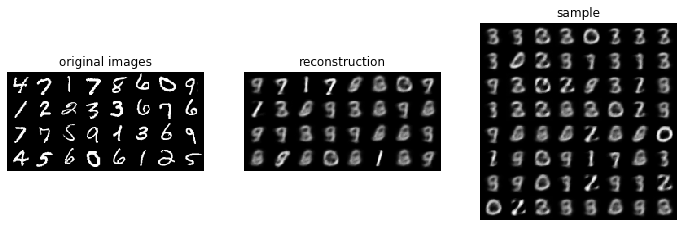

EPOCH :  1
| v_lower_bound:  10588.255126432568
EPOCH :  2
| v_lower_bound:  10390.155096448561
EPOCH :  3
| v_lower_bound:  10259.43026531683
EPOCH :  4
| v_lower_bound:  10157.104907070396
EPOCH :  5
| v_lower_bound:  10075.312066377099
EPOCH :  6
| v_lower_bound:  10005.040210845882
EPOCH :  7
| v_lower_bound:  9949.27366290062
EPOCH :  8
| v_lower_bound:  9896.605604094482
EPOCH :  9
| v_lower_bound:  9856.259200822062
EPOCH :  10
| v_lower_bound:  9817.645727487006
EPOCH :  11
| v_lower_bound:  9782.468159169277
EPOCH :  12
| v_lower_bound:  9752.307914424808
EPOCH :  13
| v_lower_bound:  9724.664191597814
EPOCH :  14
| v_lower_bound:  9701.55113626899
EPOCH :  15
| v_lower_bound:  9678.23612458772
EPOCH :  16
| v_lower_bound:  9659.460133761993
EPOCH :  17
| v_lower_bound:  9637.081831877165
EPOCH :  18
| v_lower_bound:  9618.393166352946
EPOCH :  19
| v_lower_bound:  9600.665995323328
EPOCH :  20
| v_lower_bound:  9587.091506404917


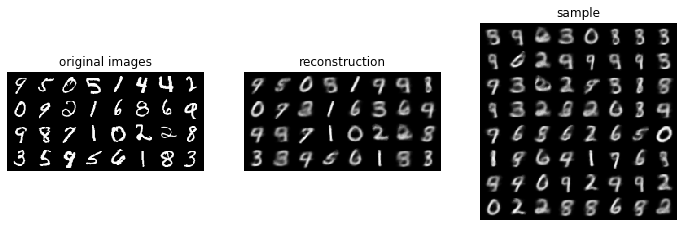

EPOCH :  21
| v_lower_bound:  9569.056999287879
EPOCH :  22
| v_lower_bound:  9551.843810384462
EPOCH :  23
| v_lower_bound:  9540.419030683635
EPOCH :  24
| v_lower_bound:  9525.85647810751
EPOCH :  25
| v_lower_bound:  9517.4093348131
EPOCH :  26
| v_lower_bound:  9501.539101541677
EPOCH :  27
| v_lower_bound:  9491.896857092885
EPOCH :  28
| v_lower_bound:  9483.848450097448
EPOCH :  29
| v_lower_bound:  9471.18603255347


In [36]:
# per epoch logging containers
v_lower_bound = []
image_and_reconstruction = []
sampled_images = []
for epoch in range(epochs):
    print("EPOCH : ",epoch)
    # per gradient step logging containers
    epoch_v_lower_bound = []
    
    for i, (images, labels) in enumerate(train_loader):
        
        # perform a gradient step
        
        # flatten and push to device
        images = images.view(-1, dim_input).to(device)
        
        # run vae
        reconstruction, mu, log_sigma_squared = vae(images)

        # loss
        loss = variational_lower_bound(images, reconstruction, mu, log_sigma_squared)
        
        # backpropagation
        optim_vae.zero_grad()
        loss.backward()
        optim_vae.step()
        
        # logging
        epoch_v_lower_bound.append(loss.item())
        
        # display stats and an image during training
        """if i % 300 == 0 :
            print("BATCH :",i)
            print("| v_lower_bound: ", epoch_v_lower_bound[i])"""

    # per epoch logging
    v_lower_bound.append(sum(epoch_v_lower_bound) / len(epoch_v_lower_bound))

    # verbose every epoch
    print("| v_lower_bound: ", v_lower_bound[-1])
    
    # logging ability to reconstruct
    
    # 1 reconstruction
    # get original images
    rec_sample = reconstruction.view(reconstruction.size(0), 1, 28, 28).detach()
    # get reconstruction
    img_sample = images.view(images.size(0), 1, 28, 28).detach()
    image_and_reconstruction.append((img_sample, rec_sample))
    # 2 sampling
    with torch.no_grad():
        vae.eval()
        fake = vae.sample_data(noise).detach().cpu()
        fake = fake.view(fake.size(0), 1, 28, 28)
    sampled_images.append(fake)
    
    if epoch % 20 == 0 :
        img, reconstruct = image_and_reconstruction[-1]
        sample = sampled_images[-1]
        draw_images(img, reconstruct, sample)

# **5 - RESULTS | LINEAR BASED VAE :**

## 1 - Training loss :

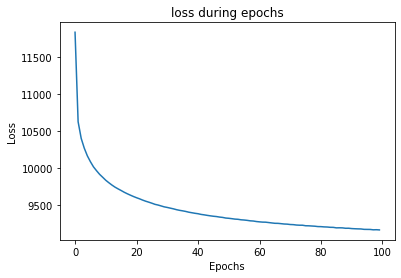

In [12]:
plt.plot(v_lower_bound)
plt.title("loss during epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.savefig("./loss_linear_vae/d_loss.png")

## 2 - Reconstruction and Sampling :

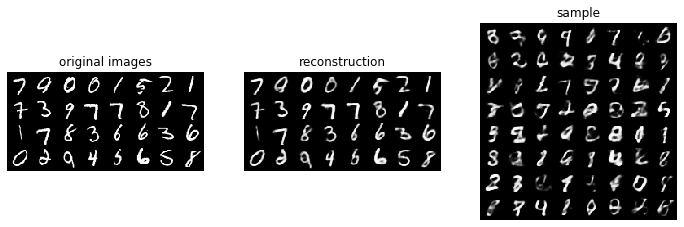

In [27]:
img, rec = image_and_reconstruction[-1]
sample = sampled_images[-1]
draw_images(img, rec, sample)

In [38]:
for i,((img, rec),sample) in enumerate(zip(image_and_reconstruction, sampled_images)):
    draw_images(img, rec, sample, mode="save", i=i)

## **THE FOLLOWING RESULTS CAN BE OBSERVED ONLY IF WE USE THE LINEAR LEYERS BASED VAE WITH A LATENT DIMENSION OF 2.**

## 3 - Distangling Factors of Variation :

torch.Size([400, 1, 28, 28])


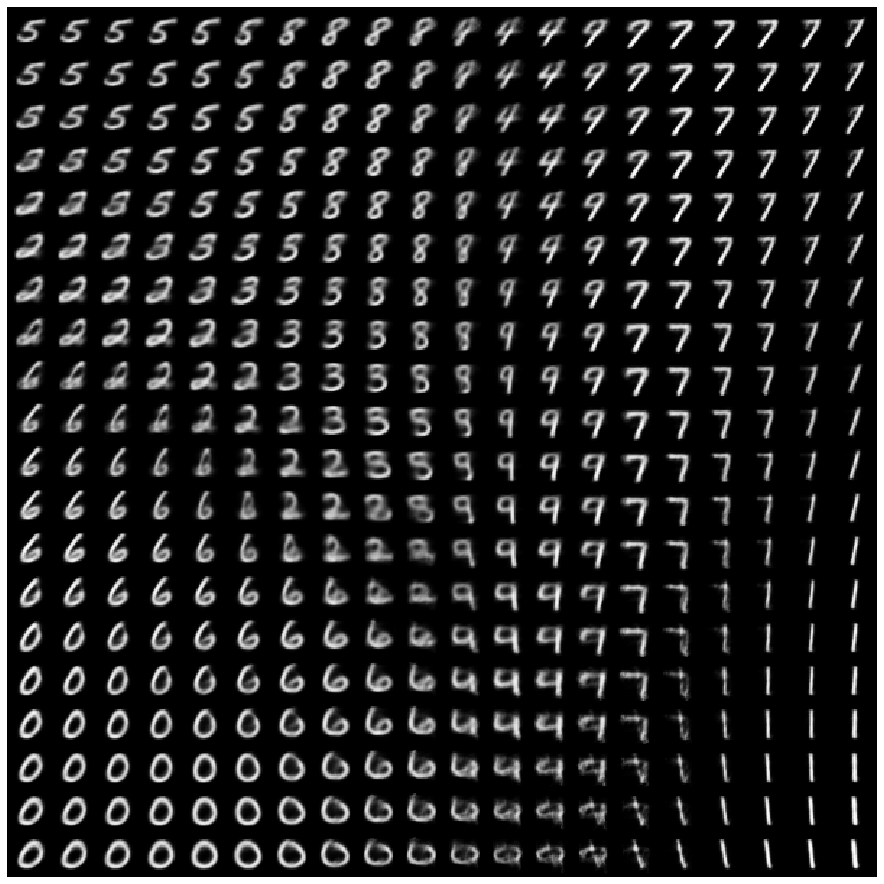

In [31]:
# create samples in the latent space continiously
with torch.no_grad():
    x = torch.linspace(-2, 2, steps=20)
    y = torch.linspace(-2, 2, steps=20)
    grid  = torch.cartesian_prod(x, y).to(device)
    # get samples for every z that we created
    samples = vae.sample_data(grid)
    samples = samples.view(samples.size(0), 1, 28, 28).detach()
    # plot the correponding reconstruction
    grid_as_img = vutils.make_grid(samples, padding=2, normalize=True,  nrow=20)
    print(samples.shape)
    plt.figure(figsize=(16,16))
    plt.axis("off")
    plt.imshow(np.transpose(grid_as_img.cpu(),(1,2,0)))
plt.savefig("./gen_linear_vae/interpolation_large.png")

# 4 - Display Embeddings :

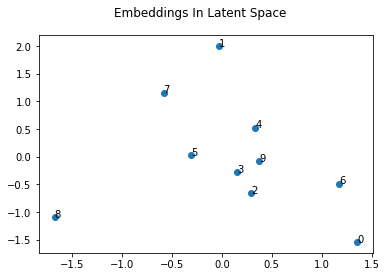

In [16]:
# get a batch of embeddings
images, labels = next(iter(test_loader))
# get an image of every class
indices = [np.where(labels.numpy() == i)[0][0] for i in range(10)]
image_per_class = images[indices].view(-1, dim_input).to(device)
# get latent representation
with torch.no_grad():
    _, mu, _ = vae(image_per_class)
    mu_np = mu.detach().cpu().numpy()

# plot every latent code with it's corresponding class
x, y = np.hsplit(mu_np, 2)
fig, ax = plt.subplots()
plt.suptitle("Embeddings In Latent Space")
ax.scatter(x, y)
for i in range(10):
    ax.annotate(str(i), (x[i], y[i])) 
plt.savefig("./gen_linear_vae/latent_space.png")